In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import requests, time, sys
import numpy as np
from datetime import date, timedelta, datetime
sys.path.append("/Users/jago/Downloads/Scweet-master/Scweet")
import scweet

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

latest_date=(date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
nations={"England":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "N. Ireland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=N92000002&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "Scotland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=S92000003&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv",
        "Wales":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=W92000004&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv"}
population={"England":56286961,
             "N. Ireland":1893700,
             "Scotland":5463300,
             "Wales":3152879}
threshold={"hospital":6,
           "deaths":6,
           "cases":6}#Usually 3 is fine but apparently we don't need data at this vital time
threshold={"hospital":6,
           "deaths":4,
           "cases":4}
average_period=7
load_new=True

Area Codes:
    England - E92000001
    N. Ireland - E92000002
    Scotland - E92000003
    Wales - E92000004

In [107]:
data={k:[] for k in nations.keys()}
for name,url in nations.items():
    if load_new==True:
        f = requests.get(url)
        with open("%s.csv"%(name),"w+") as out:
            out.seek(0)
            out.write(f.text)
            out.truncate()
    data[name]=pd.read_csv("%s.csv"%name)
    data[name]=data[name].drop(["areaType","areaCode","areaName"],axis=1)
    data[name]=data[name].rename(columns={'newAdmissions':'hospital',"newCasesBySpecimenDate":"cases","newDeaths28DaysByDeathDate":"deaths"})
    data[name].date=pd.to_datetime(data[name].date)
    for metric in ["hospital","cases","deaths"]:
        data[name][metric]=data[name][metric][threshold[metric]:]
        data[name][metric]=data[name][metric].rolling(window=average_period, min_periods=1).mean()
    data[name]=data[name].apply(lambda x: x/(population[name]/100000) if x.name in ["cases","deaths","hospital"] else x,  axis = 0)
    #data[name]=data[name].iloc[threshold:]

           date areaType   areaCode areaName  newAdmissions  \
0    2020-12-31   nation  E92000001  England            NaN   
1    2020-12-30   nation  E92000001  England            NaN   
2    2020-12-29   nation  E92000001  England            NaN   
3    2020-12-28   nation  E92000001  England         2795.0   
4    2020-12-27   nation  E92000001  England         2572.0   
..          ...      ...        ...      ...            ...   
332  2020-02-03   nation  E92000001  England            NaN   
333  2020-02-02   nation  E92000001  England            NaN   
334  2020-02-01   nation  E92000001  England            NaN   
335  2020-01-31   nation  E92000001  England            NaN   
336  2020-01-30   nation  E92000001  England            NaN   

     newCasesBySpecimenDate  newDeaths28DaysByDeathDate  
0                      1845                       136.0  
1                     24234                       369.0  
2                     58113                       469.0  
3          

In [108]:
def errorbar(x,pm):
    x = datetime.strptime(x, "%Y-%m-%d")
    l = x - timedelta(days = pm) 
    r = x + timedelta(days = pm) 
    return [l,r]

In [109]:
def plot(nations=["England","Wales"],metrics=["deaths","cases","hospital"],start_date=None,lockdowns=False):
    plt.rcParams["figure.figsize"] = (15,10)
    fig,ax=plt.subplots()
    ax2=ax.twinx()
    for metric in metrics:
        for nation in nations:
            if metric=="cases":
                ax.plot(data[nation]["date"],data[nation][metric],label="%s - %s"%(nation,metric))
            else:
                ax2.plot(data[nation]["date"],data[nation][metric],label="%s - %s"%(nation,metric),linestyle="--")
    if start_date!=None:
        plt.xlim(xmin=start_date)
    if lockdowns==True:
        if "Wales" in nations:
            ax.scatter("2020-10-23",data["Wales"].loc[data["Wales"]['date'] == "2020-10-23"]["cases"],marker="x",label="Wales Firebreak",color="red")
            ax2.scatter(["2020-11-10"],data["Wales"].loc[data["Wales"]['date'] == "2020-11-10"]["deaths"].values,marker="o",label="Wales Firebreak plus 19 days",color="red")
            ax2.plot(errorbar("2020-11-10",3.5),[data["Wales"].loc[data["Wales"]['date'] == "2020-11-10"]["deaths"].values,data["Wales"].loc[data["Wales"]['date'] == "2020-11-10"]["deaths"].values],color="red")
        if "England" in nations:
            ax.scatter("2020-11-05",data["England"].loc[data["England"]['date'] == "2020-11-05"]["cases"],marker="x",label="England LD 2",color="red")
            ax2.scatter(["2020-11-23"],data["England"].loc[data["England"]['date'] == "2020-11-23"]["deaths"].values,marker="o",label="England LD 2 plus 19 days",color="red")
            ax2.plot(errorbar("2020-11-23",3.5),[data["England"].loc[data["England"]['date'] == "2020-11-23"]["deaths"].values,data["England"].loc[data["England"]['date'] == "2020-11-23"]["deaths"].values],color="red")
            
    ax.legend()
    ax2.legend()
    ax.set_ylabel("Per 100k")
    ax2.set_ylabel("Deaths per 100k")
        

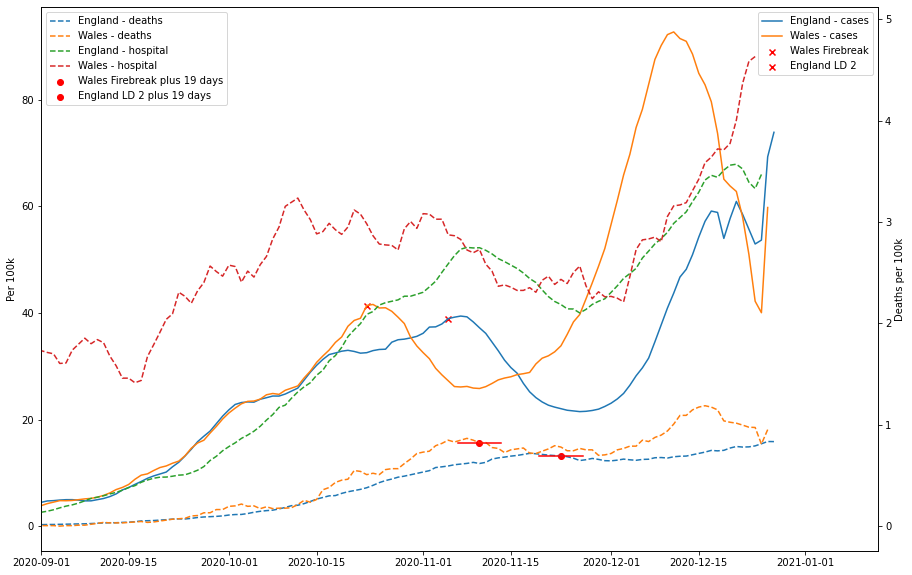

In [110]:
plot(start_date="2020-09-01",lockdowns=True)

In [112]:
data["England"][0:10]

,date,hospital,cases,deaths
0,2020-12-31,NaN,NaN,NaN
1,2020-12-30,NaN,NaN,NaN
2,2020-12-29,NaN,NaN,NaN
3,2020-12-28,NaN,NaN,NaN
4,2020-12-27,NaN,73.901663,0.833230
5,2020-12-26,NaN,69.312678,0.834119
6,2020-12-25,3.467943,53.673769,0.811911
7,2020-12-24,3.328480,52.940325,0.791036
8,2020-12-23,3.391549,55.714147,0.781353
9,2020-12-22,3.522130,58.495786,0.779340


In [19]:
42.674182*population["England"]/100000

24020.000179409024

In [ ]:
kbf_tweets=scweet.scrap(start_date="2020-01-01",max_date="2021-01-02",hashtag="kbf", interval=1,navig="chrome",headless=True,display_type="Top")

Scraping on headless mode.
looking for tweets between 2020-01-01 and 2020-01-02 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-01-01T19:33:02.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-01-02 00:00:00 and 2020-01-03 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-01-03 00:00:00 and 2020-01-04 00:00:00 ...
Tweet made at: 2020-01-03T16:46:17.000Z is found.
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-01-04 00:00:00 and 2020-01-05 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-01-05 00:00:00 and 2020-01-06 00:00:00 ...
Tweet made at: 2020-01-05T04:13:58.000Z is found.
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-01-06 00:00:00 and 2020-01-07 00:00:00 ...
Tweet made at: 2020-01-06T16:24:46.000Z is found.
Tweet made at: 2020-01-06T23:16:20.000Z is found.
scroll 0
Tweet made at: 2020-01-06T16:23:55.000Z is found.
scroll 1
scroll 2
scroll 3
looking for tweets between 2020-01-07 00:00:00 and 2

scroll 1
Tweet made at: 2020-02-12T01:55:31.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-02-13 00:00:00 and 2020-02-14 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-02-14 00:00:00 and 2020-02-15 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-02-14T16:03:27.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-02-15 00:00:00 and 2020-02-16 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-02-15T00:10:25.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-02-16 00:00:00 and 2020-02-17 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-02-16T03:14:57.000Z is found.
Tweet made at: 2020-02-16T16:51:22.000Z is found.
Tweet made at: 2020-02-16T15:36:01.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-02-17 00:00:00 and 2020-02-18 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-02-18 00:00:00 and 2020-02-19 00:00:00 ...
Tweet made at: 2020-02-18T18:30:36.000Z is found.
Tweet made at: 2020-

scroll 3
looking for tweets between 2020-03-21 00:00:00 and 2020-03-22 00:00:00 ...
scroll 0
scroll 1
scroll 2
scroll 3
looking for tweets between 2020-03-22 00:00:00 and 2020-03-23 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-03-23 00:00:00 and 2020-03-24 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-03-23T15:51:32.000Z is found.
Tweet made at: 2020-03-23T20:28:22.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-03-24 00:00:00 and 2020-03-25 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-03-25 00:00:00 and 2020-03-26 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-03-24T23:59:12.000Z is found.
Tweet made at: 2020-03-25T04:02:56.000Z is found.
Tweet made at: 2020-03-25T23:30:55.000Z is found.
Tweet made at: 2020-03-25T21:04:19.000Z is found.
Tweet made at: 2020-03-25T16:01:05.000Z is found.
Tweet made at: 2020-03-25T21:09:13.000Z is found.
scroll 2
scroll 3
scroll 4
looking for tweets between 2020-03-26 00:00:0

scroll 1
Tweet made at: 2020-05-30T13:22:22.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-05-31 00:00:00 and 2020-06-01 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-06-01 00:00:00 and 2020-06-02 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-06-01T03:41:13.000Z is found.
Tweet made at: 2020-06-01T12:27:49.000Z is found.
Tweet made at: 2020-06-01T17:23:39.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-06-02 00:00:00 and 2020-06-03 00:00:00 ...
scroll 0
scroll 1
scroll 2
looking for tweets between 2020-06-03 00:00:00 and 2020-06-04 00:00:00 ...
Tweet made at: 2020-06-03T18:50:44.000Z is found.
scroll 0
Tweet made at: 2020-06-03T18:49:55.000Z is found.
scroll 1
scroll 2
scroll 3
looking for tweets between 2020-06-04 00:00:00 and 2020-06-05 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-06-04T10:32:51.000Z is found.
Tweet made at: 2020-06-04T22:13:18.000Z is found.
scroll 2
scroll 3
looking for tweets between 2020-06-0

Tweet made at: 2020-06-22T09:31:14.000Z is found.
Tweet made at: 2020-06-22T12:51:56.000Z is found.
scroll 3
scroll 4
looking for tweets between 2020-06-23 00:00:00 and 2020-06-24 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-06-23T12:44:58.000Z is found.
Tweet made at: 2020-06-23T12:52:36.000Z is found.
Tweet made at: 2020-06-23T08:47:47.000Z is found.
Tweet made at: 2020-06-23T10:03:36.000Z is found.
Tweet made at: 2020-06-23T20:26:08.000Z is found.
Tweet made at: 2020-06-19T12:53:50.000Z is found.
Tweet made at: 2020-06-23T06:25:22.000Z is found.
scroll 2
Tweet made at: 2020-06-23T09:07:45.000Z is found.
Tweet made at: 2020-06-23T09:27:35.000Z is found.
Tweet made at: 2020-06-23T10:23:05.000Z is found.
Tweet made at: 2020-06-23T22:49:46.000Z is found.
Tweet made at: 2020-06-23T08:25:41.000Z is found.
Tweet made at: 2020-06-23T16:32:13.000Z is found.
Tweet made at: 2020-06-23T08:51:25.000Z is found.
scroll 3
Tweet made at: 2020-06-23T09:06:09.000Z is found.
Tweet made at: 2020-0

Tweet made at: 2020-07-01T14:31:15.000Z is found.
Tweet made at: 2020-07-01T15:27:31.000Z is found.
Tweet made at: 2020-05-01T09:51:35.000Z is found.
Tweet made at: 2020-07-01T21:03:29.000Z is found.
Tweet made at: 2020-07-01T20:52:53.000Z is found.
Tweet made at: 2020-07-01T17:37:39.000Z is found.
Tweet made at: 2020-07-01T16:20:49.000Z is found.
scroll 2
Tweet made at: 2020-07-01T12:54:30.000Z is found.
Tweet made at: 2020-07-01T14:23:45.000Z is found.
Tweet made at: 2020-07-01T13:39:03.000Z is found.
Tweet made at: 2020-07-01T19:02:19.000Z is found.
Tweet made at: 2020-07-01T20:20:30.000Z is found.
scroll 3
Tweet made at: 2020-07-01T11:49:37.000Z is found.
Tweet made at: 2020-07-01T18:24:13.000Z is found.
Tweet made at: 2020-07-01T14:14:44.000Z is found.
Tweet made at: 2020-07-01T17:49:24.000Z is found.
Tweet made at: 2020-07-01T09:26:29.000Z is found.
Tweet made at: 2020-07-01T23:42:08.000Z is found.
scroll 4
scroll 5
Tweet made at: 2020-07-01T15:59:01.000Z is found.
Tweet made at:

scroll 1
Tweet made at: 2020-07-06T11:57:18.000Z is found.
Tweet made at: 2020-07-06T12:47:42.000Z is found.
Tweet made at: 2020-07-06T18:37:34.000Z is found.
Tweet made at: 2020-07-06T15:18:35.000Z is found.
Tweet made at: 2020-07-06T10:39:05.000Z is found.
Tweet made at: 2020-07-06T10:56:29.000Z is found.
Tweet made at: 2020-07-06T16:52:55.000Z is found.
scroll 2
Tweet made at: 2020-07-06T15:09:41.000Z is found.
Tweet made at: 2020-07-06T10:11:22.000Z is found.
Tweet made at: 2020-05-23T17:34:30.000Z is found.
Tweet made at: 2020-07-06T17:23:12.000Z is found.
Tweet made at: 2020-07-06T19:37:09.000Z is found.
Tweet made at: 2020-07-06T20:58:06.000Z is found.
Tweet made at: 2020-07-06T10:59:14.000Z is found.
Tweet made at: 2020-07-06T11:01:01.000Z is found.
scroll 3
Tweet made at: 2020-07-06T08:33:22.000Z is found.
Tweet made at: 2020-07-06T21:11:54.000Z is found.
Tweet made at: 2020-07-06T14:53:56.000Z is found.
Tweet made at: 2020-07-06T16:13:42.000Z is found.
Tweet made at: 2020-07-

Tweet made at: 2020-07-11T09:43:53.000Z is found.
Tweet made at: 2020-07-11T17:21:18.000Z is found.
Tweet made at: 2020-07-11T21:13:35.000Z is found.
Tweet made at: 2020-07-11T19:38:56.000Z is found.
scroll 2
Tweet made at: 2020-07-10T23:58:27.000Z is found.
Tweet made at: 2020-07-11T06:54:10.000Z is found.
Tweet made at: 2020-07-11T10:37:06.000Z is found.
Tweet made at: 2020-07-10T17:54:32.000Z is found.
Tweet made at: 2020-07-11T18:24:21.000Z is found.
Tweet made at: 2020-07-11T17:42:20.000Z is found.
scroll 3
Tweet made at: 2020-07-11T11:34:44.000Z is found.
Tweet made at: 2020-07-11T22:52:54.000Z is found.
Tweet made at: 2020-07-11T08:27:00.000Z is found.
Tweet made at: 2020-07-11T09:39:27.000Z is found.
Tweet made at: 2020-07-11T19:54:24.000Z is found.
Tweet made at: 2020-07-11T17:57:22.000Z is found.
Tweet made at: 2020-07-11T09:21:58.000Z is found.
Tweet made at: 2020-07-11T15:32:37.000Z is found.
Tweet made at: 2020-07-11T05:57:53.000Z is found.
Tweet made at: 2020-07-11T13:44:

Tweet made at: 2020-07-16T09:24:29.000Z is found.
Tweet made at: 2020-07-15T11:49:52.000Z is found.
Tweet made at: 2020-07-16T09:33:47.000Z is found.
scroll 6
Tweet made at: 2020-07-16T16:14:08.000Z is found.
Tweet made at: 2020-07-16T23:48:24.000Z is found.
Tweet made at: 2020-07-16T10:53:30.000Z is found.
Tweet made at: 2020-07-16T05:31:40.000Z is found.
Tweet made at: 2020-07-16T14:39:26.000Z is found.
Tweet made at: 2020-07-16T08:05:18.000Z is found.
Tweet made at: 2020-07-16T13:51:51.000Z is found.
scroll 7
Tweet made at: 2020-07-16T09:05:49.000Z is found.
Tweet made at: 2020-07-16T20:00:58.000Z is found.
Tweet made at: 2020-07-16T10:44:43.000Z is found.
Tweet made at: 2020-07-16T15:29:27.000Z is found.
Tweet made at: 2020-07-16T13:12:33.000Z is found.
scroll 8
Tweet made at: 2020-07-16T11:24:30.000Z is found.
Tweet made at: 2020-07-16T08:33:42.000Z is found.
Tweet made at: 2020-07-16T13:22:50.000Z is found.
Tweet made at: 2020-07-16T22:24:11.000Z is found.
Tweet made at: 2020-07-

Tweet made at: 2020-08-27T19:51:51.000Z is found.
Tweet made at: 2020-08-27T11:40:44.000Z is found.
Tweet made at: 2020-08-27T19:13:09.000Z is found.
scroll 5
Tweet made at: 2020-08-27T08:55:52.000Z is found.
Tweet made at: 2020-08-27T12:51:39.000Z is found.
Tweet made at: 2020-08-27T17:30:33.000Z is found.
Tweet made at: 2020-08-27T16:12:20.000Z is found.
scroll 6
scroll 7
looking for tweets between 2020-08-28 00:00:00 and 2020-08-29 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-08-28T16:12:37.000Z is found.
Tweet made at: 2020-08-28T16:13:38.000Z is found.
Tweet made at: 2020-08-28T07:13:46.000Z is found.
Tweet made at: 2020-08-28T08:04:54.000Z is found.
Tweet made at: 2020-08-28T19:18:21.000Z is found.
scroll 2
Tweet made at: 2020-08-27T08:59:55.000Z is found.
scroll 3
scroll 4
Tweet made at: 2020-08-28T22:02:48.000Z is found.
Tweet made at: 2020-08-27T15:59:52.000Z is found.
Tweet made at: 2020-08-28T21:45:05.000Z is found.
Tweet made at: 2020-08-28T22:47:04.000Z is found.
Twe

Tweet made at: 2020-08-31T20:00:56.000Z is found.
scroll 6
Tweet made at: 2020-08-31T09:48:44.000Z is found.
Tweet made at: 2020-08-31T11:35:24.000Z is found.
Tweet made at: 2020-08-31T18:32:31.000Z is found.
Tweet made at: 2020-08-31T18:59:24.000Z is found.
Tweet made at: 2020-08-31T15:01:00.000Z is found.
Tweet made at: 2020-08-31T08:05:51.000Z is found.
scroll 7
Tweet made at: 2020-08-31T11:16:12.000Z is found.
Tweet made at: 2020-08-31T11:20:41.000Z is found.
scroll 8
scroll 9
looking for tweets between 2020-09-01 00:00:00 and 2020-09-02 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-09-01T00:10:01.000Z is found.
Tweet made at: 2020-09-01T12:59:12.000Z is found.
Tweet made at: 2020-09-01T12:05:56.000Z is found.
Tweet made at: 2020-09-01T13:10:52.000Z is found.
Tweet made at: 2020-09-01T16:55:51.000Z is found.
Tweet made at: 2020-09-01T19:01:33.000Z is found.
scroll 2
Tweet made at: 2020-09-01T07:38:29.000Z is found.
Tweet made at: 2020-09-01T08:17:08.000Z is found.
Tweet made a

Tweet made at: 2020-09-05T07:06:21.000Z is found.
Tweet made at: 2020-09-05T07:55:49.000Z is found.
Tweet made at: 2020-09-05T16:12:34.000Z is found.
Tweet made at: 2020-09-05T11:32:00.000Z is found.
Tweet made at: 2020-09-05T12:27:39.000Z is found.
scroll 3
Tweet made at: 2020-09-05T14:17:58.000Z is found.
Tweet made at: 2020-09-05T11:56:54.000Z is found.
Tweet made at: 2020-09-05T12:05:37.000Z is found.
Tweet made at: 2020-09-05T12:18:40.000Z is found.
Tweet made at: 2020-09-05T16:11:48.000Z is found.
Tweet made at: 2020-09-05T16:14:42.000Z is found.
Tweet made at: 2020-09-05T14:35:19.000Z is found.
scroll 4
Tweet made at: 2020-09-05T05:35:34.000Z is found.
Tweet made at: 2020-09-05T14:42:07.000Z is found.
Tweet made at: 2020-09-05T11:17:27.000Z is found.
Tweet made at: 2020-09-05T12:24:34.000Z is found.
Tweet made at: 2020-09-05T14:40:06.000Z is found.
Tweet made at: 2020-09-05T14:43:37.000Z is found.
Tweet made at: 2020-09-05T19:40:59.000Z is found.
scroll 5
Tweet made at: 2020-09-

scroll 9
looking for tweets between 2020-09-09 00:00:00 and 2020-09-10 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-09-09T17:53:04.000Z is found.
Tweet made at: 2020-09-09T21:07:04.000Z is found.
Tweet made at: 2020-09-09T16:54:28.000Z is found.
Tweet made at: 2020-09-09T17:56:01.000Z is found.
Tweet made at: 2020-09-09T07:52:48.000Z is found.
Tweet made at: 2020-09-09T16:17:25.000Z is found.
Tweet made at: 2020-09-09T17:45:27.000Z is found.
scroll 2
Tweet made at: 2020-09-09T21:12:01.000Z is found.
Tweet made at: 2020-09-08T21:08:56.000Z is found.
Tweet made at: 2020-09-09T00:03:39.000Z is found.
Tweet made at: 2020-09-09T12:49:27.000Z is found.
Tweet made at: 2020-09-09T12:36:59.000Z is found.
Tweet made at: 2020-09-09T16:42:35.000Z is found.
Tweet made at: 2020-09-09T12:37:48.000Z is found.
Tweet made at: 2020-09-09T18:20:49.000Z is found.
scroll 3
Tweet made at: 2020-09-09T15:10:03.000Z is found.
Tweet made at: 2020-09-09T10:21:54.000Z is found.
Tweet made at: 2020-09-09T06:4

scroll 2
Tweet made at: 2020-09-13T14:45:51.000Z is found.
Tweet made at: 2020-09-13T15:37:19.000Z is found.
Tweet made at: 2020-09-13T08:58:12.000Z is found.
Tweet made at: 2020-09-13T09:10:52.000Z is found.
Tweet made at: 2020-09-13T17:49:00.000Z is found.
Tweet made at: 2020-09-13T18:04:33.000Z is found.
Tweet made at: 2020-09-13T20:29:52.000Z is found.
Tweet made at: 2020-09-13T21:57:51.000Z is found.
scroll 3
Tweet made at: 2020-09-13T07:41:41.000Z is found.
Tweet made at: 2020-09-13T20:24:54.000Z is found.
Tweet made at: 2020-09-13T18:06:53.000Z is found.
Tweet made at: 2020-09-13T08:28:10.000Z is found.
Tweet made at: 2020-09-13T13:28:32.000Z is found.
Tweet made at: 2020-09-13T14:55:20.000Z is found.
Tweet made at: 2020-09-13T21:33:05.000Z is found.
scroll 4
Tweet made at: 2020-09-13T12:04:03.000Z is found.
Tweet made at: 2020-09-13T07:26:56.000Z is found.
Tweet made at: 2020-09-13T00:30:58.000Z is found.
Tweet made at: 2020-09-13T12:50:31.000Z is found.
Tweet made at: 2020-09-

Tweet made at: 2020-09-18T16:27:52.000Z is found.
Tweet made at: 2020-09-18T07:13:42.000Z is found.
Tweet made at: 2020-09-18T07:30:48.000Z is found.
Tweet made at: 2020-09-18T20:02:34.000Z is found.
Tweet made at: 2020-09-18T10:59:30.000Z is found.
Tweet made at: 2020-09-18T12:39:58.000Z is found.
scroll 6
scroll 7
looking for tweets between 2020-09-19 00:00:00 and 2020-09-20 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-09-19T18:05:33.000Z is found.
Tweet made at: 2020-09-19T08:23:04.000Z is found.
Tweet made at: 2020-09-19T07:43:37.000Z is found.
Tweet made at: 2020-09-19T18:33:19.000Z is found.
Tweet made at: 2020-09-19T22:21:41.000Z is found.
scroll 2
scroll 3
Tweet made at: 2020-09-19T16:45:49.000Z is found.
Tweet made at: 2020-09-19T23:06:12.000Z is found.
Tweet made at: 2020-09-19T18:09:11.000Z is found.
Tweet made at: 2020-09-19T16:31:49.000Z is found.
Tweet made at: 2020-09-19T19:01:38.000Z is found.
Tweet made at: 2020-09-19T10:24:07.000Z is found.
Tweet made at: 2020-0

scroll 4
Tweet made at: 2020-10-02T19:53:53.000Z is found.
Tweet made at: 2020-10-02T17:18:41.000Z is found.
Tweet made at: 2020-10-02T17:21:43.000Z is found.
Tweet made at: 2020-10-02T17:02:14.000Z is found.
Tweet made at: 2020-10-02T12:19:09.000Z is found.
Tweet made at: 2020-10-02T14:38:24.000Z is found.
Tweet made at: 2020-10-02T14:40:49.000Z is found.
scroll 5
Tweet made at: 2020-10-02T12:41:17.000Z is found.
Tweet made at: 2020-10-02T11:20:28.000Z is found.
Tweet made at: 2020-10-02T06:55:38.000Z is found.
Tweet made at: 2020-10-02T08:56:04.000Z is found.
Tweet made at: 2020-10-02T09:09:56.000Z is found.
Tweet made at: 2020-10-02T21:04:47.000Z is found.
scroll 6
Tweet made at: 2020-10-02T14:56:02.000Z is found.
Tweet made at: 2020-10-02T20:32:40.000Z is found.
Tweet made at: 2020-10-02T14:17:09.000Z is found.
Tweet made at: 2020-10-02T08:05:06.000Z is found.
scroll 7
scroll 8
scroll 9
looking for tweets between 2020-10-03 00:00:00 and 2020-10-04 00:00:00 ...
scroll 0
scroll 1
Twe

scroll 3
scroll 4
looking for tweets between 2020-10-11 00:00:00 and 2020-10-12 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-12 00:00:00 and 2020-10-13 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-13 00:00:00 and 2020-10-14 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-14 00:00:00 and 2020-10-15 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-15 00:00:00 and 2020-10-16 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-16 00:00:00 and 2020-10-17 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-17 00:00:00 and 2020-10-18 00:00:00 ...
scroll 0
scroll 1
looking for tweets between 2020-10-18 00:00:00 and 2020-10-19 00:00:00 ...
Tweet made at: 2020-10-18T19:00:46.000Z is found.
Tweet made at: 2020-10-18T20:21:16.000Z is found.
Tweet made at: 2020-10-18T17:41:44.000Z is found.
Tweet made at: 2020-10-18T17:37:32.000Z is found.
Tweet made at: 2020-10-18T09:43:23.000Z is found.
Tweet 

Tweet made at: 2020-10-26T11:12:44.000Z is found.
Tweet made at: 2020-10-26T17:09:09.000Z is found.
Tweet made at: 2020-10-26T23:32:40.000Z is found.
scroll 2
Tweet made at: 2020-10-26T16:19:13.000Z is found.
Tweet made at: 2020-10-26T13:09:43.000Z is found.
Tweet made at: 2020-10-26T13:13:53.000Z is found.
Tweet made at: 2020-10-26T12:35:00.000Z is found.
scroll 3
Tweet made at: 2020-10-26T17:12:12.000Z is found.
Tweet made at: 2020-10-26T18:50:43.000Z is found.
Tweet made at: 2020-10-26T11:55:03.000Z is found.
Tweet made at: 2020-10-26T14:32:06.000Z is found.
Tweet made at: 2020-10-26T00:15:26.000Z is found.
Tweet made at: 2020-10-26T21:29:55.000Z is found.
Tweet made at: 2020-10-26T22:21:50.000Z is found.
scroll 4
Tweet made at: 2020-10-26T19:10:14.000Z is found.
Tweet made at: 2020-10-26T16:30:06.000Z is found.
Tweet made at: 2020-10-26T16:52:45.000Z is found.
Tweet made at: 2020-10-26T17:51:42.000Z is found.
Tweet made at: 2020-10-26T15:38:08.000Z is found.
Tweet made at: 2020-10-

Tweet made at: 2020-11-01T01:02:51.000Z is found.
scroll 2
Tweet made at: 2020-10-31T23:46:47.000Z is found.
Tweet made at: 2020-11-01T09:31:23.000Z is found.
Tweet made at: 2020-10-31T20:57:25.000Z is found.
Tweet made at: 2020-11-01T07:13:03.000Z is found.
Tweet made at: 2020-11-01T00:12:28.000Z is found.
Tweet made at: 2020-11-01T20:03:34.000Z is found.
scroll 3
Tweet made at: 2020-11-01T12:53:22.000Z is found.
Tweet made at: 2020-11-01T20:51:49.000Z is found.
Tweet made at: 2020-11-01T09:00:15.000Z is found.
Tweet made at: 2020-11-01T15:16:05.000Z is found.
Tweet made at: 2020-11-01T23:43:09.000Z is found.
Tweet made at: 2020-11-01T19:11:28.000Z is found.
Tweet made at: 2020-11-01T09:12:28.000Z is found.
Tweet made at: 2020-11-01T11:45:21.000Z is found.
Tweet made at: 2020-11-01T15:11:08.000Z is found.
Tweet made at: 2020-11-01T16:28:35.000Z is found.
Tweet made at: 2020-11-01T20:09:17.000Z is found.
scroll 4
Tweet made at: 2020-11-01T14:48:53.000Z is found.
Tweet made at: 2020-11-

Tweet made at: 2020-11-07T17:41:30.000Z is found.
Tweet made at: 2020-11-07T12:23:23.000Z is found.
Tweet made at: 2020-11-07T18:16:33.000Z is found.
Tweet made at: 2020-11-07T01:25:19.000Z is found.
Tweet made at: 2020-11-07T11:08:41.000Z is found.
Tweet made at: 2020-11-07T16:14:57.000Z is found.
Tweet made at: 2020-11-07T23:28:49.000Z is found.
scroll 5
Tweet made at: 2020-11-07T21:35:43.000Z is found.
Tweet made at: 2020-11-07T09:24:02.000Z is found.
Tweet made at: 2020-11-07T12:09:24.000Z is found.
Tweet made at: 2020-11-07T09:20:09.000Z is found.
Tweet made at: 2020-11-07T01:06:43.000Z is found.
scroll 6
Tweet made at: 2020-11-07T09:07:21.000Z is found.
Tweet made at: 2020-11-07T10:24:10.000Z is found.
scroll 7
scroll 8
looking for tweets between 2020-11-08 00:00:00 and 2020-11-09 00:00:00 ...
scroll 0
scroll 1
Tweet made at: 2020-11-08T20:22:53.000Z is found.
Tweet made at: 2020-11-08T20:33:40.000Z is found.
Tweet made at: 2020-11-08T21:07:19.000Z is found.
Tweet made at: 2020-1

In [18]:
dates=[]
for tweet in kbf_tweets:
    dates.append(tweet[2])

In [19]:
dates

['2021-01-01T18:22:59.000Z',
 '2021-01-01T18:24:59.000Z',
 '2021-01-01T03:20:20.000Z',
 '2021-01-01T10:47:39.000Z',
 '2021-01-01T15:09:14.000Z',
 '2021-01-01T15:12:14.000Z',
 '2021-01-01T15:57:32.000Z',
 '2021-01-01T12:06:11.000Z',
 '2021-01-01T01:29:21.000Z',
 '2021-01-01T06:55:25.000Z',
 '2021-01-01T00:58:23.000Z',
 '2021-01-01T16:03:53.000Z',
 '2021-01-01T09:05:03.000Z',
 '2021-01-01T18:21:01.000Z',
 '2021-01-01T18:28:15.000Z',
 '2021-01-01T16:08:14.000Z',
 '2021-01-01T22:12:11.000Z',
 '2021-01-01T13:16:30.000Z',
 '2021-01-01T01:02:16.000Z',
 '2021-01-01T02:53:34.000Z',
 '2021-01-01T08:13:39.000Z',
 '2021-01-01T20:15:48.000Z',
 '2021-01-01T19:47:31.000Z',
 '2021-01-01T09:40:08.000Z',
 '2021-01-01T20:47:32.000Z',
 '2021-01-01T17:21:25.000Z',
 '2021-01-01T19:51:41.000Z',
 '2021-01-01T19:59:02.000Z',
 '2021-01-01T16:42:05.000Z',
 '2021-01-01T17:11:00.000Z',
 '2021-01-01T18:24:37.000Z',
 '2021-01-01T22:18:18.000Z',
 '2021-01-01T17:49:12.000Z',
 '2021-01-01T18:14:27.000Z',
 '2021-01-01T2